# Import Package

In [101]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import numpy as np
import cv2
import glob
from moviepy.editor import VideoFileClip
import moviepy as mve

%matplotlib inline

In [102]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:9999;
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

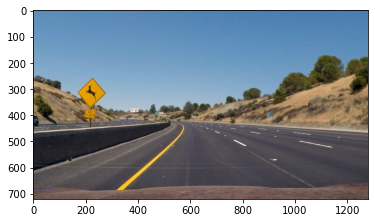

In [103]:
# Read the image
image = mpimg.imread('test_images/test2.jpg')
plt.imshow(image)

# Sobel parameter

In [104]:
# parameter
thresh_min = 50
thresh_max = 255
sobel_kernel = 3
mag_thresh = (50, 255)
dir_thresh = (0.7, 1.3)
hls_thresh = (50,255)

# Image function 

In [105]:
def color_threshold_setting(image,red_threshold=0, green_threshold=0, blue_threshold=0):
    # Grab the x and y size and make a copy of the image
    ysize = image.shape[0]
    xsize = image.shape[1]
    color_select = np.copy(image)
    # Define color selection criteria
    ###### MODIFY THESE VARIABLES TO MAKE YOUR COLOR SELECTION
    # rgb 三個顏色小於某個閥值 濾掉不看
    rgb_threshold = [red_threshold, green_threshold, blue_threshold]
    # Do a boolean or with the "|" character to identify
    # pixels below the thresholds
    # 其中一個符合 就濾掉給他等於[0,0,0] 使用 或 | 
    thresholds = (image[:,:,0] < rgb_threshold[0]) | (image[:,:,1] < rgb_threshold[1]) | (image[:,:,2] < rgb_threshold[2])
    color_select[thresholds] = [0,0,0]
    return color_select

def focus_view_triangle(image):
    # Grab the x and y size and make a copy of the image
    ysize = image.shape[0]
    xsize = image.shape[1]
    triangle_image = np.copy(image)
    # Define the vertices of a triangular mask.
    # Keep in mind the origin (x=0, y=0) is in the upper left
    # MODIFY THESE VALUES TO ISOLATE THE REGION 
    # WHERE THE LANE LINES ARE IN THE IMAGE
    left_bottom = [0+50, ysize]
    right_bottom = [1280-50, ysize]
    apex = [xsize//2, ysize//2+30]
    # Perform a linear fit (y=Ax+B) to each of the three sides of the triangle
    # np.polyfit returns the coefficients [A, B] of the fit
    fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
    fit_right = np.polyfit((right_bottom[0], apex[0]), (right_bottom[1], apex[1]), 1)
    fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)
    # Find the region inside the lines
    XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
    region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                        (YY > (XX*fit_right[0] + fit_right[1])) & \
                        (YY < (XX*fit_bottom[0] + fit_bottom[1]))
    # Color pixels red where both color and region selections met
    triangle_image[~region_thresholds] = [0, 0, 255]
#     x = [left_bottom[0], right_bottom[0], apex[0], left_bottom[0]]
#     y = [left_bottom[1], right_bottom[1], apex[1], left_bottom[1]]
#     triangle_image=plt.plot(x, y, 'b--', lw=4)
    return triangle_image

def gray_image(image):
    gray = np.copy(image)
    gray = cv2.cvtColor(gray,cv2.COLOR_RGB2GRAY)
    # Define a kernel size for Gaussian smoothing / blurring
    kernel_size = kernel_size # Must be an odd number (3, 5, 7...)
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
    # Define our parameters for Canny and run it
    low_threshold = low_threshold
    high_threshold = high_threshold
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
    return edges

def gray_drawhoughLines(image,kernel_size=3,low_threshold = 50,high_threshold = 150,
                        rho=2,theta=np.pi/180,threshold =15,min_line_length=10,max_line_gap=20):
    gray = np.copy(image)
    gray = cv2.cvtColor(gray,cv2.COLOR_RGB2GRAY)
    # Define a kernel size for Gaussian smoothing / blurring
    kernel_size = kernel_size # Must be an odd number (3, 5, 7...)
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
    # Define our parameters for Canny and run it
    low_threshold = low_threshold
    high_threshold = high_threshold
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
    # Next we'll create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255 
    # This time we are defining a four sided polygon to mask
    imshape = image.shape
#     left_bottom = [0, ysize]
#     right_bottom = [1280, ysize]
#     apex = [xsize//2, ysize//2]
    vertices = np.array([[(0,imshape[0]),(imshape[1]/2+10, imshape[0]//2+50),
                          (imshape[1]//2+10, imshape[0]//2+50), (imshape[1],imshape[0])]],
                        dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges, mask)
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = rho # distance resolution in pixels of the Hough grid
    theta = theta # angular resolution in radians of the Hough grid
    threshold = threshold  # minimum number of votes (intersections in Hough grid cell)
    min_line_length = min_line_length #minimum number of pixels making up a line
    max_line_gap = max_line_gap   # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on
    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)
    # Iterate over the output "lines" and draw lines on a blank image
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges)) 

    # Draw the lines on the edge image
    lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
    return lines_edges
# image = mpimg.imread("camera_cal/calibration1.jpg")
# plt.imshow(image)
# some image can't find the right corner
# don't count it
# checkerboard = mpimg.imread('camera_cal/calibration1.jpg')
# # convert to grayscale
# gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# # find the chessboard corners
# pattern_size=(9,6)
# f, corners = cv2.findChessboardCorners(gray, pattern_size, None)
# f
# from skimage import io
# fname = 'camera_cal/calibration2.jpg'
# img = io.imread(fname)
# fname = 'camera_cal/calibration2.jpg'
# img = cv2.imread(fname)
# prepare object points
nx = 9 # count by yourself
ny = 6 # count by yourself
pattern_size=(9,6)
fnames = glob.glob("camera_cal/calibration*.jpg")
pattern = np.zeros((pattern_size[1] * pattern_size[0], 3), np.float32)
pattern[:, :2] = np.mgrid[0:pattern_size[0], 0:pattern_size[1]].T.reshape(-1, 2)
pattern_points = [] # points in real world image
image_points = []   # points in image plane
image_size = None
calibrated_images=[]
failed_images=[]
for fname in fnames:
    checkerboard = mpimg.imread(fname)
    gray = cv2.cvtColor(checkerboard, cv2.COLOR_RGB2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret:
        pattern_points.append(pattern)
        image_points.append(corners)
        image_size = (checkerboard.shape[1], checkerboard.shape[0])
        cv2.drawChessboardCorners(checkerboard, (nx, ny), corners, ret)
        calibrated_images.append(checkerboard)
    else:
        failed_images.append(checkerboard)
if pattern_points and image_points:
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(pattern_points, image_points, image_size,None,None)
    
    
def undistort(image, pattern_points=pattern_points, image_points=image_points):
    """ undistort image """
    undistort_image=cv2.undistort(image, mtx, dist, None, mtx)
    return undistort_image
# TODO 
# 找出可以看到頂角的圖片留下 處理 
# 找不到的去掉 
# 留下的建了 還原失真矩陣
# calibrated_camera_images = (glob.glob('camera_cal/calibration*.jpg'))
# fnames = glob.glob("camera_cal/calibration*.jpg")
# for fname in fnames:
#     image = mpimg.imread(fname)
#     print(image.shape)
# 視野角度 處理
def perspective_transform(image):
    # 圖片的 寬 高
    height = image.shape[0]
    width = image.shape[1]
    # Quadrangle verties coordinates in the source image
    # 取要關注的點
    s1 = [width // 2 - 76, height * 0.625]
    s2 = [width // 2 + 76, height * 0.625]
    s3 = [-100, height]
    s4 = [width + 100, height]
    src = np.float32([s1, s2, s3, s4])
    # Quadrangle verties coordinates in the destination image
    # 轉成自己要的圖片
    d1 = [100, 0]
    d2 = [width - 100, 0]
    d3 = [100, height]
    d4 = [width - 100, height]
    dst = np.float32([d1, d2, d3, d4])
    # Given src and dst points we calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image
    warped = cv2.warpPerspective(image, M, (width, height))
    # We also calculate the oposite transform
    unwrap_m = cv2.getPerspectiveTransform(dst, src)
    # Return the resulting image and matrix 
    return (warped, unwrap_m)

# Calibrated Check

Corners detected:


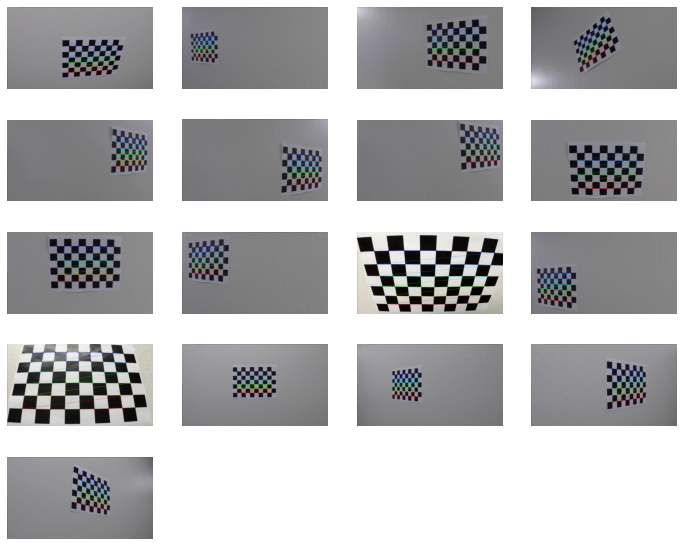

Unable to detect corners:


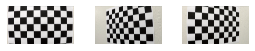

In [106]:
plt.figure(figsize=(12, 10))
gridspec.GridSpec(5, 4)
print('Corners detected:')
# Loop through the images and look for the chessboard corners
for i, calibrated_images, in enumerate(calibrated_images):
    plt.subplot2grid((5, 4), (i//4, i%4), colspan=1, rowspan=1)
    plt.imshow(calibrated_images)
    plt.axis('off')
plt.show()
print('Unable to detect corners:')
for i, failed_images, in enumerate(failed_images):
    plt.subplot2grid((5, 4), (i//4, i%4), colspan=1, rowspan=1)
    plt.imshow(failed_images)
    plt.axis('off')
plt.show()

# Sobel combined function 

In [107]:
def hls_select(image, thresh=hls_thresh):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    hls_output = np.zeros_like(s_channel)
    hls_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return hls_output


def Sobel_Operator(image,axis='x',thresh_min=thresh_min,thresh_max = thresh_max):
    image_c = np.copy(image)
#   gray = cv2.cvtColor(image_c, cv2.COLOR_RGB2GRAY)
#   hls = cv2.cvtColor(np.copy(image_c), cv2.COLOR_RGB2HLS).astype(np.float)
#   s = hls[:, :, 2]
    if axis == 'x':      
        abs_sobel = np.absolute(cv2.Sobel(image_c, cv2.CV_64F, 1, 0))
    elif axis == 'y':      
        abs_sobel = np.absolute(cv2.Sobel(image_c, cv2.CV_64F, 0, 1))
    thresh_min = thresh_min
    thresh_max = thresh_max
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    output = np.zeros_like(scaled_sobel)
    output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return output      
# output=Sobel_Operator(image,axis='x')
# plt.imshow(output, cmap='gray')
# show_bf_af_image(image,binary_output)
def mag_thresh(image, sobel_kernel=sobel_kernel, mag_thresh=mag_thresh):
    # Convert to grayscale
    image_c = np.copy(image)
#   gray = cv2.cvtColor(image_c, cv2.COLOR_RGB2GRAY)
#     hls = cv2.cvtColor(np.copy(image_c), cv2.COLOR_RGB2HLS).astype(np.float)
#     s = hls[:, :, 2]
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(image_c, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image_c, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    output_mag = np.zeros_like(gradmag)
    output_mag[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    # Return the binary image
    return output_mag
# output_mag=mag_thresh(image)
# plt.imshow(output_mag)
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(image, sobel_kernel=3, thresh=dir_thresh):
    # Grayscale
    image_c = np.copy(image)
#   gray = cv2.cvtColor(image_c, cv2.COLOR_RGB2GRAY)
#     hls = cv2.cvtColor(np.copy(image_c), cv2.COLOR_RGB2HLS).astype(np.float)
#     s = hls[:, :, 2]
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(image_c, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image_c, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output_dir =  np.zeros_like(absgraddir)
    binary_output_dir[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # Return the binary image
    return binary_output_dir
# binary_output_dir=dir_threshold(image)
# plt.imshow(binary_output_dir)
def Sobel_combined(image):
#     image_c = np.copy(image)
    image_c=hls_select(image)
    gradx = Sobel_Operator(image_c)
    grady = Sobel_Operator(image_c)
    mag_binary = mag_thresh(image_c)
    dir_binary = dir_threshold(image_c)
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

# Finding the Lines: Sliding Window

In [108]:
# Load our image
def find_lane_pixels(image):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(image[image.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((image, image, image))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(image.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = image.shape[0] - (window+1)*window_height
        win_y_high = image.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    if len(leftx) == 0:
        left_fit =[]
    else:
        left_fit = np.polyfit(lefty, leftx, 2)
    
    if len(rightx) == 0:
        right_fit =[]
    else:
        right_fit = np.polyfit(righty, rightx, 2)
    

    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )



    return left_fit, right_fit,out_img, lefty, leftx, righty, rightx, ploty


# def fit_polynomial(image):
#     # Find our lane pixels first
#     leftx, lefty, rightx, righty, out_img = find_lane_pixels(image)

#     # Fit a second order polynomial to each using `np.polyfit`
#     left_fit = np.polyfit(lefty, leftx, 2)
#     right_fit = np.polyfit(righty, rightx, 2)

#     # Generate x and y values for plotting
#     ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
#     try:
#         left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
#         right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
#     except TypeError:
#         # Avoids an error if `left` and `right_fit` are still none or incorrect
#         print('The function failed to fit a line!')
#         left_fitx = 1*ploty**2 + 1*ploty
#         right_fitx = 1*ploty**2 + 1*ploty

#     ## Visualization ##
#     # Colors in the left and right lane regions
#     out_img[lefty, leftx] = [255, 0, 0]
#     out_img[righty, rightx] = [0, 0, 255]

#     # Plots the left and right polynomials on the lane lines
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
#     return  out_img, left_fit, right_fit, ploty, lefty, leftx, righty, rightx

def curvatures(lefty, leftx, righty, rightx, ploty):
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/730 # meters per pixel in x dimension
    
    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
#     if lefty & leftx
    
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    return left_curverad, right_curverad

# Finding the Lines: Search from Prior

In [109]:
# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!
# left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
# right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

# def fit_poly(img_shape, leftx, lefty, rightx, righty):
#      ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
#     left_fit = np.polyfit(lefty, leftx, 2)
#     right_fit = np.polyfit(righty, rightx, 2)
#     # Generate x and y values for plotting
#     ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
#     ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
#     left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
#     right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
#     return left_fitx, right_fitx, ploty

# def search_around_poly(binary_warped):
#     # HYPERPARAMETER
#     # Choose the width of the margin around the previous polynomial to search
#     # The quiz grader expects 100 here, but feel free to tune on your own!
#     margin = 100

#     # Grab activated pixels
#     nonzero = binary_warped.nonzero()
#     nonzeroy = np.array(nonzero[0])
#     nonzerox = np.array(nonzero[1])
    
#     ### TO-DO: Set the area of search based on activated x-values ###
#     ### within the +/- margin of our polynomial function ###
#     ### Hint: consider the window areas for the similarly named variables ###
#     ### in the previous quiz, but change the windows to our new search area ###
#     left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
#                     left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
#                     left_fit[1]*nonzeroy + left_fit[2] + margin)))
#     right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
#                     right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
#                     right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
#     # Again, extract left and right line pixel positions
#     leftx = nonzerox[left_lane_inds]
#     lefty = nonzeroy[left_lane_inds] 
#     rightx = nonzerox[right_lane_inds]
#     righty = nonzeroy[right_lane_inds]

#     # Fit new polynomials
#     left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
#     ## Visualization ##
#     # Create an image to draw on and an image to show the selection window
#     out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
#     window_img = np.zeros_like(out_img)
#     # Color in left and right line pixels
#     out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
#     out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

#     # Generate a polygon to illustrate the search window area
#     # And recast the x and y points into usable format for cv2.fillPoly()
#     left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
#     left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
#                               ploty])))])
#     left_line_pts = np.hstack((left_line_window1, left_line_window2))
#     right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
#     right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
#                               ploty])))])
#     right_line_pts = np.hstack((right_line_window1, right_line_window2))

#     # Draw the lane onto the warped blank image
#     cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
#     cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
#     result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
#     # Plot the polynomial lines onto the image
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
#     ## End visualization steps ##
    
#     return result

# Myself function 

In [110]:
def show_bf_af_image(before,after):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(48, 18))
    f.tight_layout()
    ax1.imshow(before)
    ax1.set_title('Before Image', fontsize=20)
    ax2.imshow(after)
    ax2.set_title('After Image', fontsize=20)
    plt.subplots_adjust(left=0.2, right=0.4, top=0.9, bottom=0.5)
    
def is_same_image(image1,image2):
    difference = cv2.subtract(image1, image2)
    find = not np.any(difference) #if difference is all zeros it will return False
    if image.shape==edges.shape==0:
        result = "兩張圖片格式就已經不同了"
    elif find is True:
        result = "兩張圖片一樣"
    else:
        cv2.imwrite("result.jpg", difference)
        result = "兩張圖片不一樣"
    return result

# Color,View amd Hough

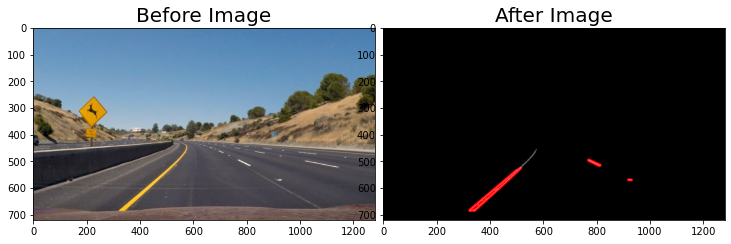

In [111]:
color_select = color_threshold_setting(image,250,0,0)
triangle_image = focus_view_triangle(color_select)
lines_edges = gray_drawhoughLines(triangle_image)
# Uncomment the following code if you are running the code locally and wish to save the image
# mpimg.imsave("test-after.png", color_select)
show_bf_af_image(image,lines_edges)

# Undistort

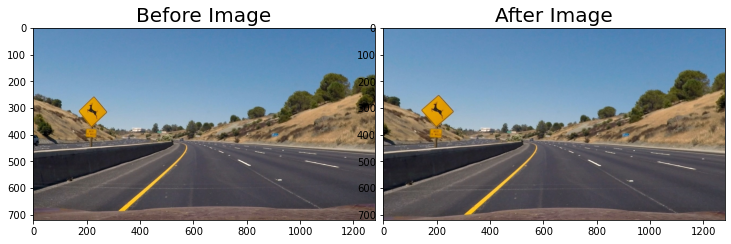

In [112]:
undistort_image=undistort(image)
show_bf_af_image(image,undistort_image)

# Perspective

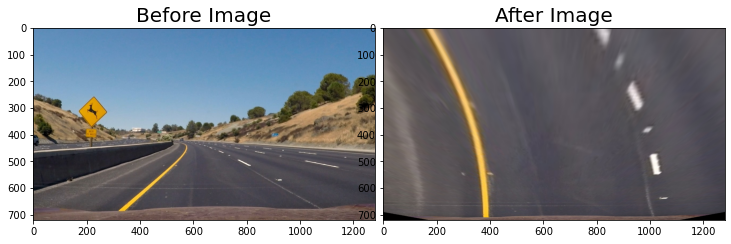

In [113]:
# 將每一個圖片轉換
# for image in glob.glob('test_images/test*.jpg'):
#     image = mpimg.imread(image)
#     transformed, _ = perspective_transform(image) 
    
#     _, (x1, x2) = plt.subplots(1, 2, figsize=(24, 9))
#     x1.axis('off')
#     x1.imshow(image)
#     x1.set_title('Original', fontsize=20)

#     x2.axis('off')
#     x2.imshow(transformed)
#     x2.set_title('Transformed', fontsize=20)
transformed, utransformed = perspective_transform(image) 
show_bf_af_image(image,transformed)

# Sobel

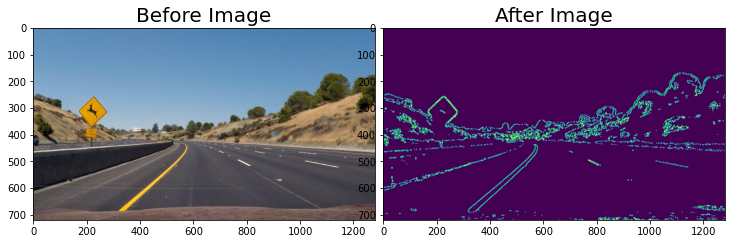

In [114]:
test=Sobel_combined(image)
show_bf_af_image(image,test)

# Combined

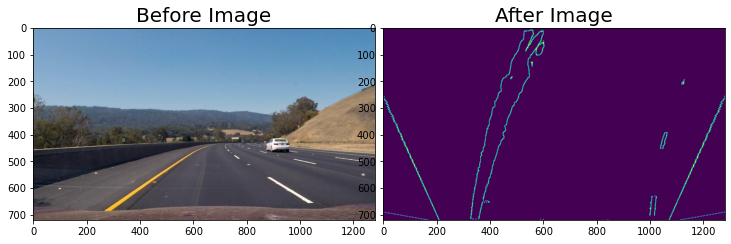

In [122]:
def combined(image):
    undistort_image=undistort(image)
#    color_select = color_threshold_setting(undistort_image,250,0,0)
    triangle_image = focus_view_triangle(undistort_image)
#     lines_edges = gray_drawhoughLines(triangle_image)
    transformed, utransformed = perspective_transform(triangle_image) 
    image=Sobel_combined(transformed)
    return image,utransformed
# Uncomment the following code if you are running the code locally and wish to save the image
# mpimg.imsave("test-after.png", color_select)
test,utransformed=combined(image)
show_bf_af_image(image,test)

# Detecting Lanes using Histogram

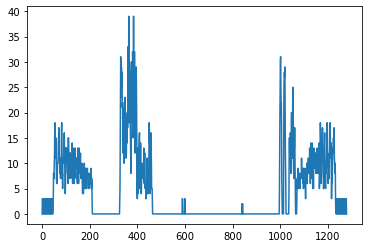

In [123]:
binary_warped,utransformed=combined(image)
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

# Slide Window

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


680.19945190643 m 319.24410961303266 m


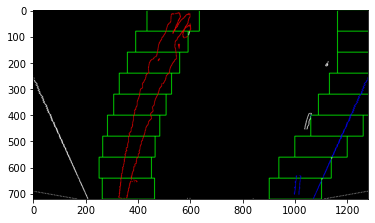

In [124]:
test,utransformed=combined(image)
# out_img,left_fit, right_fit,ploty,out_img, lefty, leftx, righty, rightx = fitlines(binary_warped)
left_fit, right_fit,out_img, lefty, leftx, righty, rightx, ploty = find_lane_pixels(test)
#Testing Function
left_curverad, right_curverad = curvatures(lefty, leftx, righty, rightx, ploty)    
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
plt.imshow(out_img)

# Search from Prior

In [125]:
# result = search_around_poly(test)
# # View your output
# plt.imshow(result)

In [131]:
def draw_lane(img, warped, left_fit, right_fit, ploty, left_curverad, right_curverad, utransformed):

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, utransformed, (image.shape[1], image.shape[0])) 
    
    # Creating Text and set font parameters
    TextL = "Left  Curvature: " + str(int(left_curverad)) + " m"
    TextR = "Right Curvature: " + str(int(right_curverad))+ " m"
    fontScale=1.5
    thickness=3
    fontFace = cv2.FONT_HERSHEY_SIMPLEX

    # Using CV2 putText to write text into images
    cv2.putText(newwarp, TextL, (110,60), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(newwarp, TextR, (110,110), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)

    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    return result

# Testing the Function
# drawed_lane = draw_lane(img, binary_warped, left_fit, right_fit, ploty, left_curverad, right_curverad, utransformed)
# # Plot the Result
# plt.figure(figsize=(20,10))
# plt.imshow(drawed_lane)

In [159]:
def pipeline(image):
    # creating a Binary Undistorced Warped Image
    trans, utransformed = combined(image)
    # Fiting Lines
    left_fit, right_fit,out_img, lefty, leftx, righty, rightx, ploty = find_lane_pixels(trans) 
    # Calulating the left and right lines curvatures
    left_curverad, right_curverad = curvatures(lefty, leftx, righty, rightx, ploty)
    # Draw Lane between road lines
    result_lane = draw_lane(image, trans, left_fit, right_fit, ploty, left_curverad, right_curverad, utransformed)                              
    return result_lane   

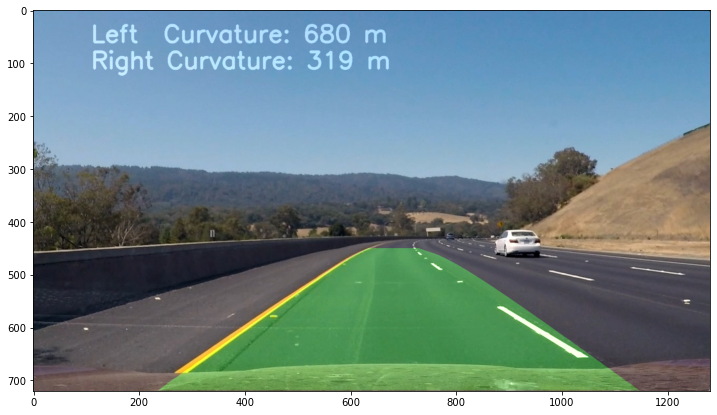

In [167]:
#read image
image = mpimg.imread('test_images/test3.jpg')
resultado = pipeline(image)
plt.figure(figsize=(15,7))
plt.imshow(resultado)

# Output_images

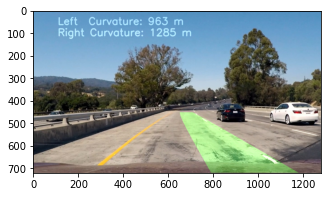

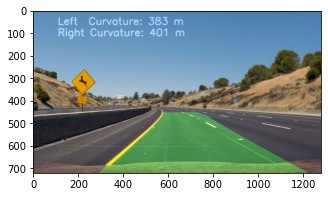

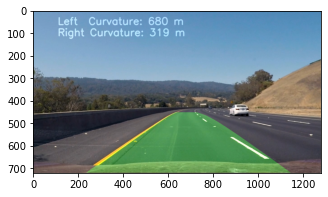

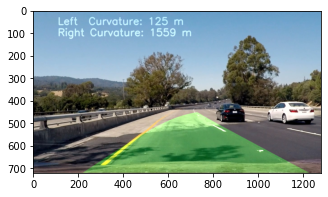

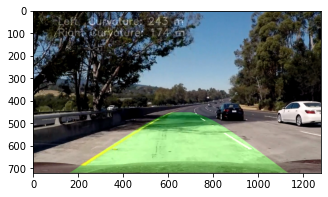

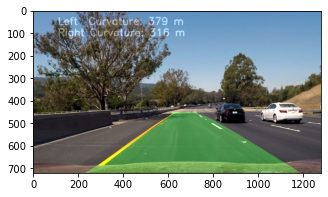

In [209]:
# test_images = glob.glob('test_images/test*.jpg')
for image_path in glob.glob('test_images/test*.jpg'):
    image = mpimg.imread(image_path)
    edit = pipeline(image)
   
    mpimg.imsave(image_path.replace('test_images', 'output_images'), edit)
    plt.figure(figsize=(5, 2.5))
    plt.imshow(edit)
    plt.subplots_adjust(left=0.0, right=1, top=0.9, bottom=0.0)
    plt.show() 

In [134]:
#Create video file pipeline
output = 'out_test_video.mp4'
clip1 = VideoFileClip("videos/project_video.mp4")
#clip1 = VideoFileClip("project_video.mp4").subclip(1,2)

out_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output, audio=False)

                                                               
                                                            

t:  46%|████▌     | 579/1260 [16:37<01:36,  7.08it/s, now=None]

                                                               [A
                                                            

t:  46%|████▌     | 579/1260 [16:37<01:36,  7.08it/s, now=None]

t:  23%|██▎       | 113/485 [00:56<00:59,  6.27it/s, now=None]


t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]


t:   0%|          | 2/1260 [00:00<01:39, 12.69it/s, now=None]

Moviepy - Building video out_test_video.mp4.
Moviepy - Writing video out_test_video.mp4






t:   0%|          | 3/1260 [00:00<02:10,  9.65it/s, now=None]


t:   0%|          | 4/1260 [00:00<02:34,  8.14it/s, now=None]


t:   0%|          | 5/1260 [00:00<02:47,  7.49it/s, now=None]


t:   0%|          | 6/1260 [00:00<02:57,  7.07it/s, now=None]


t:   1%|          | 7/1260 [00:00<03:02,  6.87it/s, now=None]


t:   1%|          | 8/1260 [00:01<03:13,  6.48it/s, now=None]


t:   1%|          | 9/1260 [00:01<03:13,  6.46it/s, now=None]


t:   1%|          | 10/1260 [00:01<03:09,  6.59it/s, now=None]


t:   1%|          | 11/1260 [00:01<03:10,  6.57it/s, now=None]


t:   1%|          | 12/1260 [00:01<03:10,  6.54it/s, now=None]


t:   1%|          | 13/1260 [00:01<03:09,  6.57it/s, now=None]


t:   1%|          | 14/1260 [00:02<03:09,  6.56it/s, now=None]


t:   1%|          | 15/1260 [00:02<03:13,  6.42it/s, now=None]


t:   1%|▏         | 16/1260 [00:02<03:12,  6.47it/s, now=None]


t:   1%|▏         | 17/1260 [00:02<03:13,  6.41it/s, now=None]


t:   1%|▏         | 18/1260 [

t:   9%|▉         | 113/1260 [00:17<03:22,  5.68it/s, now=None]


t:   9%|▉         | 114/1260 [00:18<03:18,  5.77it/s, now=None]


t:   9%|▉         | 115/1260 [00:18<03:22,  5.65it/s, now=None]


t:   9%|▉         | 116/1260 [00:18<03:24,  5.61it/s, now=None]


t:   9%|▉         | 117/1260 [00:18<03:24,  5.58it/s, now=None]


t:   9%|▉         | 118/1260 [00:18<03:16,  5.81it/s, now=None]


t:   9%|▉         | 119/1260 [00:18<03:12,  5.94it/s, now=None]


t:  10%|▉         | 120/1260 [00:19<03:06,  6.12it/s, now=None]


t:  10%|▉         | 121/1260 [00:19<03:06,  6.10it/s, now=None]


t:  10%|▉         | 122/1260 [00:19<03:12,  5.92it/s, now=None]


t:  10%|▉         | 123/1260 [00:19<03:13,  5.89it/s, now=None]


t:  10%|▉         | 124/1260 [00:19<03:07,  6.06it/s, now=None]


t:  10%|▉         | 125/1260 [00:19<03:06,  6.08it/s, now=None]


t:  10%|█         | 126/1260 [00:20<03:03,  6.19it/s, now=None]


t:  10%|█         | 127/1260 [00:20<03:00,  6.26it/s, now=None]


t:  10%|█ 

t:  18%|█▊        | 222/1260 [00:35<02:44,  6.31it/s, now=None]


t:  18%|█▊        | 223/1260 [00:35<02:52,  6.02it/s, now=None]


t:  18%|█▊        | 224/1260 [00:36<02:49,  6.11it/s, now=None]


t:  18%|█▊        | 225/1260 [00:36<02:50,  6.06it/s, now=None]


t:  18%|█▊        | 226/1260 [00:36<02:48,  6.13it/s, now=None]


t:  18%|█▊        | 227/1260 [00:36<02:45,  6.24it/s, now=None]


t:  18%|█▊        | 228/1260 [00:36<02:50,  6.06it/s, now=None]


t:  18%|█▊        | 229/1260 [00:36<02:47,  6.14it/s, now=None]


t:  18%|█▊        | 230/1260 [00:37<02:43,  6.28it/s, now=None]


t:  18%|█▊        | 231/1260 [00:37<02:45,  6.21it/s, now=None]


t:  18%|█▊        | 232/1260 [00:37<02:42,  6.33it/s, now=None]


t:  18%|█▊        | 233/1260 [00:37<02:41,  6.36it/s, now=None]


t:  19%|█▊        | 234/1260 [00:37<02:40,  6.38it/s, now=None]


t:  19%|█▊        | 235/1260 [00:37<02:39,  6.44it/s, now=None]


t:  19%|█▊        | 236/1260 [00:37<02:42,  6.29it/s, now=None]


t:  19%|█▉

t:  26%|██▋       | 331/1260 [00:53<02:26,  6.33it/s, now=None]


t:  26%|██▋       | 332/1260 [00:53<02:23,  6.47it/s, now=None]


t:  26%|██▋       | 333/1260 [00:53<02:24,  6.42it/s, now=None]


t:  27%|██▋       | 334/1260 [00:53<02:23,  6.44it/s, now=None]


t:  27%|██▋       | 335/1260 [00:53<02:30,  6.14it/s, now=None]


t:  27%|██▋       | 336/1260 [00:54<02:32,  6.06it/s, now=None]


t:  27%|██▋       | 337/1260 [00:54<02:33,  6.03it/s, now=None]


t:  27%|██▋       | 338/1260 [00:54<02:30,  6.11it/s, now=None]


t:  27%|██▋       | 339/1260 [00:54<02:33,  6.01it/s, now=None]


t:  27%|██▋       | 340/1260 [00:54<02:32,  6.03it/s, now=None]


t:  27%|██▋       | 341/1260 [00:54<02:30,  6.10it/s, now=None]


t:  27%|██▋       | 342/1260 [00:55<02:31,  6.06it/s, now=None]


t:  27%|██▋       | 343/1260 [00:55<02:30,  6.08it/s, now=None]


t:  27%|██▋       | 344/1260 [00:55<02:31,  6.03it/s, now=None]


t:  27%|██▋       | 345/1260 [00:55<02:31,  6.05it/s, now=None]


t:  27%|██

t:  35%|███▍      | 440/1260 [01:11<02:23,  5.70it/s, now=None]


t:  35%|███▌      | 441/1260 [01:11<02:23,  5.70it/s, now=None]


t:  35%|███▌      | 442/1260 [01:11<02:20,  5.82it/s, now=None]


t:  35%|███▌      | 443/1260 [01:11<02:18,  5.91it/s, now=None]


t:  35%|███▌      | 444/1260 [01:11<02:16,  5.98it/s, now=None]


t:  35%|███▌      | 445/1260 [01:12<02:18,  5.89it/s, now=None]


t:  35%|███▌      | 446/1260 [01:12<02:13,  6.10it/s, now=None]


t:  35%|███▌      | 447/1260 [01:12<02:12,  6.16it/s, now=None]


t:  36%|███▌      | 448/1260 [01:12<02:13,  6.08it/s, now=None]


t:  36%|███▌      | 449/1260 [01:12<02:11,  6.16it/s, now=None]


t:  36%|███▌      | 450/1260 [01:12<02:13,  6.08it/s, now=None]


t:  36%|███▌      | 451/1260 [01:12<02:11,  6.15it/s, now=None]


t:  36%|███▌      | 452/1260 [01:13<02:10,  6.19it/s, now=None]


t:  36%|███▌      | 453/1260 [01:13<02:18,  5.83it/s, now=None]


t:  36%|███▌      | 454/1260 [01:13<02:20,  5.76it/s, now=None]


t:  36%|██

t:  44%|████▎     | 549/1260 [01:29<01:55,  6.18it/s, now=None]


t:  44%|████▎     | 550/1260 [01:29<01:55,  6.15it/s, now=None]


t:  44%|████▎     | 551/1260 [01:30<01:55,  6.12it/s, now=None]


t:  44%|████▍     | 552/1260 [01:30<01:56,  6.09it/s, now=None]


t:  44%|████▍     | 553/1260 [01:30<02:00,  5.87it/s, now=None]


t:  44%|████▍     | 554/1260 [01:30<01:58,  5.97it/s, now=None]


t:  44%|████▍     | 555/1260 [01:30<01:59,  5.89it/s, now=None]


t:  44%|████▍     | 556/1260 [01:30<01:58,  5.97it/s, now=None]


t:  44%|████▍     | 557/1260 [01:31<01:57,  6.00it/s, now=None]


t:  44%|████▍     | 558/1260 [01:31<01:54,  6.10it/s, now=None]


t:  44%|████▍     | 559/1260 [01:31<01:54,  6.10it/s, now=None]


t:  44%|████▍     | 560/1260 [01:31<01:52,  6.23it/s, now=None]


t:  45%|████▍     | 561/1260 [01:31<01:52,  6.19it/s, now=None]


t:  45%|████▍     | 562/1260 [01:31<01:53,  6.13it/s, now=None]


t:  45%|████▍     | 563/1260 [01:31<01:53,  6.12it/s, now=None]


t:  45%|██

t:  52%|█████▏    | 658/1260 [01:47<01:38,  6.12it/s, now=None]


t:  52%|█████▏    | 659/1260 [01:47<01:36,  6.23it/s, now=None]


t:  52%|█████▏    | 660/1260 [01:47<01:37,  6.17it/s, now=None]


t:  52%|█████▏    | 661/1260 [01:47<01:36,  6.22it/s, now=None]


t:  53%|█████▎    | 662/1260 [01:47<01:36,  6.20it/s, now=None]


t:  53%|█████▎    | 663/1260 [01:48<01:37,  6.15it/s, now=None]


t:  53%|█████▎    | 664/1260 [01:48<01:35,  6.24it/s, now=None]


t:  53%|█████▎    | 665/1260 [01:48<01:34,  6.33it/s, now=None]


t:  53%|█████▎    | 666/1260 [01:48<01:36,  6.18it/s, now=None]


t:  53%|█████▎    | 667/1260 [01:48<01:37,  6.08it/s, now=None]


t:  53%|█████▎    | 668/1260 [01:48<01:39,  5.94it/s, now=None]


t:  53%|█████▎    | 669/1260 [01:49<01:39,  5.93it/s, now=None]


t:  53%|█████▎    | 670/1260 [01:49<01:37,  6.07it/s, now=None]


t:  53%|█████▎    | 671/1260 [01:49<01:39,  5.94it/s, now=None]


t:  53%|█████▎    | 672/1260 [01:49<01:37,  6.04it/s, now=None]


t:  53%|██

t:  61%|██████    | 767/1260 [02:04<01:18,  6.28it/s, now=None]


t:  61%|██████    | 768/1260 [02:04<01:16,  6.47it/s, now=None]


t:  61%|██████    | 769/1260 [02:04<01:18,  6.22it/s, now=None]


t:  61%|██████    | 770/1260 [02:04<01:17,  6.34it/s, now=None]


t:  61%|██████    | 771/1260 [02:04<01:16,  6.38it/s, now=None]


t:  61%|██████▏   | 772/1260 [02:05<01:16,  6.37it/s, now=None]


t:  61%|██████▏   | 773/1260 [02:05<01:15,  6.43it/s, now=None]


t:  61%|██████▏   | 774/1260 [02:05<01:14,  6.54it/s, now=None]


t:  62%|██████▏   | 775/1260 [02:05<01:14,  6.52it/s, now=None]


t:  62%|██████▏   | 776/1260 [02:05<01:14,  6.53it/s, now=None]


t:  62%|██████▏   | 777/1260 [02:05<01:15,  6.44it/s, now=None]


t:  62%|██████▏   | 778/1260 [02:06<01:13,  6.53it/s, now=None]


t:  62%|██████▏   | 779/1260 [02:06<01:14,  6.48it/s, now=None]


t:  62%|██████▏   | 780/1260 [02:06<01:14,  6.47it/s, now=None]


t:  62%|██████▏   | 781/1260 [02:06<01:12,  6.61it/s, now=None]


t:  62%|██

t:  70%|██████▉   | 876/1260 [02:21<01:00,  6.39it/s, now=None]


t:  70%|██████▉   | 877/1260 [02:21<00:59,  6.43it/s, now=None]


t:  70%|██████▉   | 878/1260 [02:21<00:58,  6.54it/s, now=None]


t:  70%|██████▉   | 879/1260 [02:21<00:58,  6.48it/s, now=None]


t:  70%|██████▉   | 880/1260 [02:21<00:58,  6.48it/s, now=None]


t:  70%|██████▉   | 881/1260 [02:22<00:58,  6.49it/s, now=None]


t:  70%|███████   | 882/1260 [02:22<00:58,  6.48it/s, now=None]


t:  70%|███████   | 883/1260 [02:22<01:00,  6.26it/s, now=None]


t:  70%|███████   | 884/1260 [02:22<00:58,  6.46it/s, now=None]


t:  70%|███████   | 885/1260 [02:22<00:58,  6.45it/s, now=None]


t:  70%|███████   | 886/1260 [02:22<00:57,  6.52it/s, now=None]


t:  70%|███████   | 887/1260 [02:22<00:57,  6.45it/s, now=None]


t:  70%|███████   | 888/1260 [02:23<00:59,  6.27it/s, now=None]


t:  71%|███████   | 889/1260 [02:23<00:58,  6.38it/s, now=None]


t:  71%|███████   | 890/1260 [02:23<00:56,  6.56it/s, now=None]


t:  71%|██

t:  78%|███████▊  | 985/1260 [02:38<00:43,  6.31it/s, now=None]


t:  78%|███████▊  | 986/1260 [02:38<00:42,  6.42it/s, now=None]


t:  78%|███████▊  | 987/1260 [02:38<00:41,  6.51it/s, now=None]


t:  78%|███████▊  | 988/1260 [02:38<00:41,  6.50it/s, now=None]


t:  78%|███████▊  | 989/1260 [02:38<00:42,  6.41it/s, now=None]


t:  79%|███████▊  | 990/1260 [02:38<00:42,  6.39it/s, now=None]


t:  79%|███████▊  | 991/1260 [02:39<00:42,  6.33it/s, now=None]


t:  79%|███████▊  | 992/1260 [02:39<00:42,  6.35it/s, now=None]


t:  79%|███████▉  | 993/1260 [02:39<00:41,  6.44it/s, now=None]


t:  79%|███████▉  | 994/1260 [02:39<00:41,  6.47it/s, now=None]


t:  79%|███████▉  | 995/1260 [02:39<00:41,  6.43it/s, now=None]


t:  79%|███████▉  | 996/1260 [02:39<00:43,  6.03it/s, now=None]


t:  79%|███████▉  | 997/1260 [02:40<00:43,  6.02it/s, now=None]


t:  79%|███████▉  | 998/1260 [02:40<00:44,  5.91it/s, now=None]


t:  79%|███████▉  | 999/1260 [02:40<00:42,  6.08it/s, now=None]


t:  79%|██

t:  87%|████████▋ | 1093/1260 [02:55<00:25,  6.43it/s, now=None]


t:  87%|████████▋ | 1094/1260 [02:55<00:25,  6.57it/s, now=None]


t:  87%|████████▋ | 1095/1260 [02:55<00:24,  6.63it/s, now=None]


t:  87%|████████▋ | 1096/1260 [02:55<00:25,  6.38it/s, now=None]


t:  87%|████████▋ | 1097/1260 [02:55<00:25,  6.43it/s, now=None]


t:  87%|████████▋ | 1098/1260 [02:56<00:25,  6.40it/s, now=None]


t:  87%|████████▋ | 1099/1260 [02:56<00:25,  6.23it/s, now=None]


t:  87%|████████▋ | 1100/1260 [02:56<00:25,  6.38it/s, now=None]


t:  87%|████████▋ | 1101/1260 [02:56<00:24,  6.46it/s, now=None]


t:  87%|████████▋ | 1102/1260 [02:56<00:24,  6.45it/s, now=None]


t:  88%|████████▊ | 1103/1260 [02:56<00:24,  6.42it/s, now=None]


t:  88%|████████▊ | 1104/1260 [02:56<00:24,  6.31it/s, now=None]


t:  88%|████████▊ | 1105/1260 [02:57<00:24,  6.27it/s, now=None]


t:  88%|████████▊ | 1106/1260 [02:57<00:24,  6.16it/s, now=None]


t:  88%|████████▊ | 1107/1260 [02:57<00:24,  6.35it/s, now=Non

t:  95%|█████████▌| 1200/1260 [03:11<00:09,  6.43it/s, now=None]


t:  95%|█████████▌| 1201/1260 [03:12<00:09,  6.46it/s, now=None]


t:  95%|█████████▌| 1202/1260 [03:12<00:08,  6.53it/s, now=None]


t:  95%|█████████▌| 1203/1260 [03:12<00:08,  6.41it/s, now=None]


t:  96%|█████████▌| 1204/1260 [03:12<00:08,  6.47it/s, now=None]


t:  96%|█████████▌| 1205/1260 [03:12<00:08,  6.48it/s, now=None]


t:  96%|█████████▌| 1206/1260 [03:12<00:08,  6.48it/s, now=None]


t:  96%|█████████▌| 1207/1260 [03:12<00:08,  6.42it/s, now=None]


t:  96%|█████████▌| 1208/1260 [03:13<00:08,  6.45it/s, now=None]


t:  96%|█████████▌| 1209/1260 [03:13<00:08,  6.33it/s, now=None]


t:  96%|█████████▌| 1210/1260 [03:13<00:07,  6.53it/s, now=None]


t:  96%|█████████▌| 1211/1260 [03:13<00:07,  6.53it/s, now=None]


t:  96%|█████████▌| 1212/1260 [03:13<00:07,  6.50it/s, now=None]


t:  96%|█████████▋| 1213/1260 [03:13<00:07,  6.42it/s, now=None]


t:  96%|█████████▋| 1214/1260 [03:14<00:07,  6.31it/s, now=Non

Moviepy - Done !
Moviepy - video ready out_test_video.mp4
Wall time: 3min 21s


In [135]:
#Create video file pipeline
output = 'out_test_challenge_video.mp4'
clip1 = VideoFileClip("videos/challenge_video.mp4")
#clip1 = VideoFileClip("project_video.mp4").subclip(1,2)

out_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output, audio=False)

                                                               
                                                            

t:  46%|████▌     | 579/1260 [19:59<01:36,  7.08it/s, now=None]

                                                               [A
                                                            

t:  46%|████▌     | 579/1260 [19:59<01:36,  7.08it/s, now=None]

t:  23%|██▎       | 113/485 [04:19<00:59,  6.27it/s, now=None]


t:   0%|          | 0/485 [00:00<?, ?it/s, now=None]


t:   0%|          | 2/485 [00:00<00:35, 13.74it/s, now=None]

Moviepy - Building video out_test_challenge_video.mp4.
Moviepy - Writing video out_test_challenge_video.mp4






t:   1%|          | 3/485 [00:00<00:45, 10.51it/s, now=None]


t:   1%|          | 4/485 [00:00<00:54,  8.87it/s, now=None]


t:   1%|          | 5/485 [00:00<00:59,  8.02it/s, now=None]


t:   1%|          | 6/485 [00:00<01:04,  7.44it/s, now=None]


t:   1%|▏         | 7/485 [00:00<01:08,  7.01it/s, now=None]


t:   2%|▏         | 8/485 [00:01<01:08,  6.98it/s, now=None]


t:   2%|▏         | 9/485 [00:01<01:09,  6.88it/s, now=None]


t:   2%|▏         | 10/485 [00:01<01:11,  6.67it/s, now=None]


t:   2%|▏         | 11/485 [00:01<01:12,  6.53it/s, now=None]


t:   2%|▏         | 12/485 [00:01<01:13,  6.41it/s, now=None]


t:   3%|▎         | 13/485 [00:01<01:13,  6.39it/s, now=None]


t:   3%|▎         | 14/485 [00:02<01:12,  6.52it/s, now=None]


t:   3%|▎         | 15/485 [00:02<01:11,  6.55it/s, now=None]


t:   3%|▎         | 16/485 [00:02<01:11,  6.60it/s, now=None]


t:   4%|▎         | 17/485 [00:02<01:10,  6.63it/s, now=None]


t:   4%|▎         | 18/485 [00:02<01:11,  6.

t:  24%|██▎       | 115/485 [00:17<01:00,  6.16it/s, now=None]


t:  24%|██▍       | 116/485 [00:17<00:59,  6.16it/s, now=None]


t:  24%|██▍       | 117/485 [00:17<00:59,  6.22it/s, now=None]


t:  24%|██▍       | 118/485 [00:18<00:58,  6.28it/s, now=None]


t:  25%|██▍       | 119/485 [00:18<00:58,  6.27it/s, now=None]


t:  25%|██▍       | 120/485 [00:18<00:58,  6.28it/s, now=None]


t:  25%|██▍       | 121/485 [00:18<00:57,  6.28it/s, now=None]


t:  25%|██▌       | 122/485 [00:18<00:58,  6.25it/s, now=None]


t:  25%|██▌       | 123/485 [00:18<00:57,  6.25it/s, now=None]


t:  26%|██▌       | 124/485 [00:19<00:56,  6.43it/s, now=None]


t:  26%|██▌       | 125/485 [00:19<00:56,  6.40it/s, now=None]


t:  26%|██▌       | 126/485 [00:19<00:55,  6.42it/s, now=None]


t:  26%|██▌       | 127/485 [00:19<00:56,  6.33it/s, now=None]


t:  26%|██▋       | 128/485 [00:19<00:56,  6.29it/s, now=None]


t:  27%|██▋       | 129/485 [00:19<00:56,  6.33it/s, now=None]


t:  27%|██▋       | 130/4

t:  46%|████▋     | 225/485 [00:34<00:40,  6.40it/s, now=None]


t:  47%|████▋     | 226/485 [00:34<00:40,  6.37it/s, now=None]


t:  47%|████▋     | 227/485 [00:35<00:39,  6.46it/s, now=None]


t:  47%|████▋     | 228/485 [00:35<00:39,  6.45it/s, now=None]


t:  47%|████▋     | 229/485 [00:35<00:40,  6.35it/s, now=None]


t:  47%|████▋     | 230/485 [00:35<00:39,  6.44it/s, now=None]


t:  48%|████▊     | 231/485 [00:35<00:39,  6.45it/s, now=None]


t:  48%|████▊     | 232/485 [00:35<00:39,  6.48it/s, now=None]


t:  48%|████▊     | 233/485 [00:36<00:38,  6.53it/s, now=None]


t:  48%|████▊     | 234/485 [00:36<00:38,  6.45it/s, now=None]


t:  48%|████▊     | 235/485 [00:36<00:38,  6.52it/s, now=None]


t:  49%|████▊     | 236/485 [00:36<00:38,  6.52it/s, now=None]


t:  49%|████▉     | 237/485 [00:36<00:38,  6.43it/s, now=None]


t:  49%|████▉     | 238/485 [00:36<00:38,  6.44it/s, now=None]


t:  49%|████▉     | 239/485 [00:36<00:38,  6.46it/s, now=None]


t:  49%|████▉     | 240/4

t:  69%|██████▉   | 335/485 [00:51<00:23,  6.39it/s, now=None]


t:  69%|██████▉   | 336/485 [00:52<00:22,  6.48it/s, now=None]


t:  69%|██████▉   | 337/485 [00:52<00:22,  6.56it/s, now=None]


t:  70%|██████▉   | 338/485 [00:52<00:23,  6.36it/s, now=None]


t:  70%|██████▉   | 339/485 [00:52<00:22,  6.38it/s, now=None]


t:  70%|███████   | 340/485 [00:52<00:22,  6.47it/s, now=None]


t:  70%|███████   | 341/485 [00:52<00:22,  6.32it/s, now=None]


t:  71%|███████   | 342/485 [00:52<00:22,  6.36it/s, now=None]


t:  71%|███████   | 343/485 [00:53<00:21,  6.48it/s, now=None]


t:  71%|███████   | 344/485 [00:53<00:22,  6.33it/s, now=None]


t:  71%|███████   | 345/485 [00:53<00:21,  6.42it/s, now=None]


t:  71%|███████▏  | 346/485 [00:53<00:21,  6.44it/s, now=None]


t:  72%|███████▏  | 347/485 [00:53<00:21,  6.41it/s, now=None]


t:  72%|███████▏  | 348/485 [00:53<00:21,  6.43it/s, now=None]


t:  72%|███████▏  | 349/485 [00:54<00:20,  6.58it/s, now=None]


t:  72%|███████▏  | 350/4

t:  92%|█████████▏| 445/485 [01:08<00:06,  6.46it/s, now=None]


t:  92%|█████████▏| 446/485 [01:09<00:05,  6.51it/s, now=None]


t:  92%|█████████▏| 447/485 [01:09<00:05,  6.60it/s, now=None]


t:  92%|█████████▏| 448/485 [01:09<00:05,  6.56it/s, now=None]


t:  93%|█████████▎| 449/485 [01:09<00:05,  6.58it/s, now=None]


t:  93%|█████████▎| 450/485 [01:09<00:05,  6.52it/s, now=None]


t:  93%|█████████▎| 451/485 [01:09<00:05,  6.46it/s, now=None]


t:  93%|█████████▎| 452/485 [01:09<00:05,  6.34it/s, now=None]


t:  93%|█████████▎| 453/485 [01:10<00:04,  6.47it/s, now=None]


t:  94%|█████████▎| 454/485 [01:10<00:04,  6.47it/s, now=None]


t:  94%|█████████▍| 455/485 [01:10<00:04,  6.53it/s, now=None]


t:  94%|█████████▍| 456/485 [01:10<00:04,  6.44it/s, now=None]


t:  94%|█████████▍| 457/485 [01:10<00:04,  6.47it/s, now=None]


t:  94%|█████████▍| 458/485 [01:10<00:04,  6.29it/s, now=None]


t:  95%|█████████▍| 459/485 [01:11<00:04,  6.38it/s, now=None]


t:  95%|█████████▍| 460/4

Moviepy - Done !
Moviepy - video ready out_test_challenge_video.mp4
Wall time: 1min 15s


In [136]:
#Create video file pipeline
output = 'out_test_harder_challenge_video.mp4'
clip1 = VideoFileClip("videos/harder_challenge_video.mp4")
#clip1 = VideoFileClip("project_video.mp4").subclip(1,2)

out_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output, audio=False)

                                                               
                                                            

t:  46%|████▌     | 579/1260 [21:15<01:36,  7.08it/s, now=None]

                                                               [A
                                                            

t:  46%|████▌     | 579/1260 [21:15<01:36,  7.08it/s, now=None]

t:  23%|██▎       | 113/485 [05:35<00:59,  6.27it/s, now=None]


t:   0%|          | 0/1199 [00:00<?, ?it/s, now=None]


t:   0%|          | 2/1199 [00:00<01:28, 13.45it/s, now=None]

Moviepy - Building video out_test_harder_challenge_video.mp4.
Moviepy - Writing video out_test_harder_challenge_video.mp4






t:   0%|          | 3/1199 [00:00<02:00,  9.92it/s, now=None]


t:   0%|          | 4/1199 [00:00<02:24,  8.27it/s, now=None]


t:   0%|          | 5/1199 [00:00<02:35,  7.69it/s, now=None]


t:   1%|          | 6/1199 [00:00<02:45,  7.19it/s, now=None]


t:   1%|          | 7/1199 [00:00<02:48,  7.07it/s, now=None]


t:   1%|          | 8/1199 [00:01<02:50,  6.97it/s, now=None]


t:   1%|          | 9/1199 [00:01<02:56,  6.74it/s, now=None]


t:   1%|          | 10/1199 [00:01<03:00,  6.60it/s, now=None]


t:   1%|          | 11/1199 [00:01<02:59,  6.60it/s, now=None]


t:   1%|          | 12/1199 [00:01<03:06,  6.38it/s, now=None]


t:   1%|          | 13/1199 [00:01<03:03,  6.46it/s, now=None]


t:   1%|          | 14/1199 [00:02<03:01,  6.52it/s, now=None]


t:   1%|▏         | 15/1199 [00:02<03:03,  6.47it/s, now=None]


t:   1%|▏         | 16/1199 [00:02<03:00,  6.55it/s, now=None]


t:   1%|▏         | 17/1199 [00:02<03:01,  6.51it/s, now=None]


t:   2%|▏         | 18/1199 [

t:   9%|▉         | 113/1199 [00:17<02:49,  6.41it/s, now=None]


t:  10%|▉         | 114/1199 [00:17<02:50,  6.37it/s, now=None]


t:  10%|▉         | 115/1199 [00:17<02:49,  6.41it/s, now=None]


t:  10%|▉         | 116/1199 [00:18<02:48,  6.43it/s, now=None]


t:  10%|▉         | 117/1199 [00:18<02:48,  6.41it/s, now=None]


t:  10%|▉         | 118/1199 [00:18<02:47,  6.44it/s, now=None]


t:  10%|▉         | 119/1199 [00:18<02:51,  6.28it/s, now=None]


t:  10%|█         | 120/1199 [00:18<02:51,  6.30it/s, now=None]


t:  10%|█         | 121/1199 [00:18<02:48,  6.40it/s, now=None]


t:  10%|█         | 122/1199 [00:19<02:49,  6.37it/s, now=None]


t:  10%|█         | 123/1199 [00:19<02:50,  6.33it/s, now=None]


t:  10%|█         | 124/1199 [00:19<02:48,  6.38it/s, now=None]


t:  10%|█         | 125/1199 [00:19<02:51,  6.25it/s, now=None]


t:  11%|█         | 126/1199 [00:19<02:50,  6.29it/s, now=None]


t:  11%|█         | 127/1199 [00:19<02:47,  6.39it/s, now=None]


t:  11%|█ 

t:  19%|█▊        | 222/1199 [00:34<02:36,  6.24it/s, now=None]


t:  19%|█▊        | 223/1199 [00:35<02:36,  6.24it/s, now=None]


t:  19%|█▊        | 224/1199 [00:35<02:34,  6.33it/s, now=None]


t:  19%|█▉        | 225/1199 [00:35<02:41,  6.05it/s, now=None]


t:  19%|█▉        | 226/1199 [00:35<02:44,  5.92it/s, now=None]


t:  19%|█▉        | 227/1199 [00:35<02:39,  6.10it/s, now=None]


t:  19%|█▉        | 228/1199 [00:35<02:37,  6.17it/s, now=None]


t:  19%|█▉        | 229/1199 [00:36<02:35,  6.22it/s, now=None]


t:  19%|█▉        | 230/1199 [00:36<02:35,  6.24it/s, now=None]


t:  19%|█▉        | 231/1199 [00:36<02:35,  6.23it/s, now=None]


t:  19%|█▉        | 232/1199 [00:36<02:39,  6.05it/s, now=None]


t:  19%|█▉        | 233/1199 [00:36<02:36,  6.17it/s, now=None]


t:  20%|█▉        | 234/1199 [00:36<02:35,  6.20it/s, now=None]


t:  20%|█▉        | 235/1199 [00:36<02:33,  6.26it/s, now=None]


t:  20%|█▉        | 236/1199 [00:37<02:33,  6.29it/s, now=None]


t:  20%|█▉

t:  28%|██▊       | 331/1199 [00:52<02:18,  6.25it/s, now=None]


t:  28%|██▊       | 332/1199 [00:52<02:16,  6.33it/s, now=None]


t:  28%|██▊       | 333/1199 [00:52<02:17,  6.29it/s, now=None]


t:  28%|██▊       | 334/1199 [00:52<02:16,  6.35it/s, now=None]


t:  28%|██▊       | 335/1199 [00:52<02:15,  6.36it/s, now=None]


t:  28%|██▊       | 336/1199 [00:53<02:19,  6.17it/s, now=None]


t:  28%|██▊       | 337/1199 [00:53<02:19,  6.20it/s, now=None]


t:  28%|██▊       | 338/1199 [00:53<02:20,  6.13it/s, now=None]


t:  28%|██▊       | 339/1199 [00:53<02:23,  6.00it/s, now=None]


t:  28%|██▊       | 340/1199 [00:53<02:22,  6.02it/s, now=None]


t:  28%|██▊       | 341/1199 [00:53<02:19,  6.16it/s, now=None]


t:  29%|██▊       | 342/1199 [00:54<02:19,  6.15it/s, now=None]


t:  29%|██▊       | 343/1199 [00:54<02:17,  6.21it/s, now=None]


t:  29%|██▊       | 344/1199 [00:54<02:16,  6.28it/s, now=None]


t:  29%|██▉       | 345/1199 [00:54<02:19,  6.12it/s, now=None]


t:  29%|██

t:  37%|███▋      | 440/1199 [01:09<02:01,  6.23it/s, now=None]


t:  37%|███▋      | 441/1199 [01:09<02:03,  6.12it/s, now=None]


t:  37%|███▋      | 442/1199 [01:10<02:01,  6.24it/s, now=None]


t:  37%|███▋      | 443/1199 [01:10<02:01,  6.20it/s, now=None]


t:  37%|███▋      | 444/1199 [01:10<02:01,  6.21it/s, now=None]


t:  37%|███▋      | 445/1199 [01:10<02:00,  6.28it/s, now=None]


t:  37%|███▋      | 446/1199 [01:10<02:00,  6.26it/s, now=None]


t:  37%|███▋      | 447/1199 [01:10<01:58,  6.35it/s, now=None]


t:  37%|███▋      | 448/1199 [01:11<01:58,  6.32it/s, now=None]


t:  37%|███▋      | 449/1199 [01:11<01:58,  6.30it/s, now=None]


t:  38%|███▊      | 450/1199 [01:11<01:57,  6.35it/s, now=None]


t:  38%|███▊      | 451/1199 [01:11<01:59,  6.26it/s, now=None]


t:  38%|███▊      | 452/1199 [01:11<02:00,  6.20it/s, now=None]


t:  38%|███▊      | 453/1199 [01:11<02:03,  6.05it/s, now=None]


t:  38%|███▊      | 454/1199 [01:12<02:05,  5.94it/s, now=None]


t:  38%|██

t:  46%|████▌     | 549/1199 [01:27<01:41,  6.42it/s, now=None]


t:  46%|████▌     | 550/1199 [01:27<01:41,  6.39it/s, now=None]


t:  46%|████▌     | 551/1199 [01:27<01:40,  6.44it/s, now=None]


t:  46%|████▌     | 552/1199 [01:27<01:42,  6.33it/s, now=None]


t:  46%|████▌     | 553/1199 [01:27<01:42,  6.32it/s, now=None]


t:  46%|████▌     | 554/1199 [01:27<01:40,  6.41it/s, now=None]


t:  46%|████▋     | 555/1199 [01:28<01:41,  6.35it/s, now=None]


t:  46%|████▋     | 556/1199 [01:28<01:40,  6.42it/s, now=None]


t:  46%|████▋     | 557/1199 [01:28<01:40,  6.40it/s, now=None]


t:  47%|████▋     | 558/1199 [01:28<01:41,  6.33it/s, now=None]


t:  47%|████▋     | 559/1199 [01:28<01:39,  6.41it/s, now=None]


t:  47%|████▋     | 560/1199 [01:28<01:40,  6.38it/s, now=None]


t:  47%|████▋     | 561/1199 [01:29<01:39,  6.41it/s, now=None]


t:  47%|████▋     | 562/1199 [01:29<01:39,  6.41it/s, now=None]


t:  47%|████▋     | 563/1199 [01:29<01:41,  6.28it/s, now=None]


t:  47%|██

t:  55%|█████▍    | 658/1199 [01:44<01:27,  6.20it/s, now=None]


t:  55%|█████▍    | 659/1199 [01:44<01:25,  6.29it/s, now=None]


t:  55%|█████▌    | 660/1199 [01:44<01:25,  6.27it/s, now=None]


t:  55%|█████▌    | 661/1199 [01:45<01:27,  6.17it/s, now=None]


t:  55%|█████▌    | 662/1199 [01:45<01:26,  6.19it/s, now=None]


t:  55%|█████▌    | 663/1199 [01:45<01:26,  6.18it/s, now=None]


t:  55%|█████▌    | 664/1199 [01:45<01:25,  6.26it/s, now=None]


t:  55%|█████▌    | 665/1199 [01:45<01:24,  6.34it/s, now=None]


t:  56%|█████▌    | 666/1199 [01:45<01:24,  6.30it/s, now=None]


t:  56%|█████▌    | 667/1199 [01:46<01:23,  6.34it/s, now=None]


t:  56%|█████▌    | 668/1199 [01:46<01:24,  6.27it/s, now=None]


t:  56%|█████▌    | 669/1199 [01:46<01:25,  6.23it/s, now=None]


t:  56%|█████▌    | 670/1199 [01:46<01:23,  6.30it/s, now=None]


t:  56%|█████▌    | 671/1199 [01:46<01:23,  6.33it/s, now=None]


t:  56%|█████▌    | 672/1199 [01:46<01:23,  6.32it/s, now=None]


t:  56%|██

t:  64%|██████▍   | 767/1199 [02:02<01:10,  6.15it/s, now=None]


t:  64%|██████▍   | 768/1199 [02:02<01:09,  6.19it/s, now=None]


t:  64%|██████▍   | 769/1199 [02:02<01:08,  6.28it/s, now=None]


t:  64%|██████▍   | 770/1199 [02:02<01:08,  6.26it/s, now=None]


t:  64%|██████▍   | 771/1199 [02:02<01:08,  6.24it/s, now=None]


t:  64%|██████▍   | 772/1199 [02:02<01:07,  6.30it/s, now=None]


t:  64%|██████▍   | 773/1199 [02:02<01:07,  6.28it/s, now=None]


t:  65%|██████▍   | 774/1199 [02:03<01:09,  6.16it/s, now=None]


t:  65%|██████▍   | 775/1199 [02:03<01:09,  6.11it/s, now=None]


t:  65%|██████▍   | 776/1199 [02:03<01:09,  6.11it/s, now=None]


t:  65%|██████▍   | 777/1199 [02:03<01:08,  6.12it/s, now=None]


t:  65%|██████▍   | 778/1199 [02:03<01:07,  6.21it/s, now=None]


t:  65%|██████▍   | 779/1199 [02:03<01:07,  6.20it/s, now=None]


t:  65%|██████▌   | 780/1199 [02:04<01:08,  6.12it/s, now=None]


t:  65%|██████▌   | 781/1199 [02:04<01:07,  6.21it/s, now=None]


t:  65%|██

t:  73%|███████▎  | 876/1199 [02:19<00:51,  6.22it/s, now=None]


t:  73%|███████▎  | 877/1199 [02:19<00:51,  6.22it/s, now=None]


t:  73%|███████▎  | 878/1199 [02:19<00:51,  6.19it/s, now=None]


t:  73%|███████▎  | 879/1199 [02:20<00:52,  6.15it/s, now=None]


t:  73%|███████▎  | 880/1199 [02:20<00:50,  6.30it/s, now=None]


t:  73%|███████▎  | 881/1199 [02:20<00:50,  6.29it/s, now=None]


t:  74%|███████▎  | 882/1199 [02:20<00:49,  6.34it/s, now=None]


t:  74%|███████▎  | 883/1199 [02:20<00:50,  6.30it/s, now=None]


t:  74%|███████▎  | 884/1199 [02:20<00:50,  6.23it/s, now=None]


t:  74%|███████▍  | 885/1199 [02:21<00:49,  6.35it/s, now=None]


t:  74%|███████▍  | 886/1199 [02:21<00:48,  6.39it/s, now=None]


t:  74%|███████▍  | 887/1199 [02:21<00:50,  6.20it/s, now=None]


t:  74%|███████▍  | 888/1199 [02:21<00:51,  6.03it/s, now=None]


t:  74%|███████▍  | 889/1199 [02:21<00:50,  6.10it/s, now=None]


t:  74%|███████▍  | 890/1199 [02:21<00:50,  6.10it/s, now=None]


t:  74%|██

t:  82%|████████▏ | 985/1199 [02:36<00:34,  6.24it/s, now=None]


t:  82%|████████▏ | 986/1199 [02:37<00:33,  6.29it/s, now=None]


t:  82%|████████▏ | 987/1199 [02:37<00:33,  6.42it/s, now=None]


t:  82%|████████▏ | 988/1199 [02:37<00:32,  6.51it/s, now=None]


t:  82%|████████▏ | 989/1199 [02:37<00:32,  6.47it/s, now=None]


t:  83%|████████▎ | 990/1199 [02:37<00:32,  6.52it/s, now=None]


t:  83%|████████▎ | 991/1199 [02:37<00:32,  6.36it/s, now=None]


t:  83%|████████▎ | 992/1199 [02:37<00:32,  6.37it/s, now=None]


t:  83%|████████▎ | 993/1199 [02:38<00:31,  6.58it/s, now=None]


t:  83%|████████▎ | 994/1199 [02:38<00:31,  6.58it/s, now=None]


t:  83%|████████▎ | 995/1199 [02:38<00:32,  6.36it/s, now=None]


t:  83%|████████▎ | 996/1199 [02:38<00:31,  6.37it/s, now=None]


t:  83%|████████▎ | 997/1199 [02:38<00:31,  6.37it/s, now=None]


t:  83%|████████▎ | 998/1199 [02:38<00:31,  6.40it/s, now=None]


t:  83%|████████▎ | 999/1199 [02:39<00:31,  6.37it/s, now=None]


t:  83%|██

t:  91%|█████████ | 1093/1199 [02:53<00:17,  6.13it/s, now=None]


t:  91%|█████████ | 1094/1199 [02:53<00:17,  6.17it/s, now=None]


t:  91%|█████████▏| 1095/1199 [02:54<00:16,  6.23it/s, now=None]


t:  91%|█████████▏| 1096/1199 [02:54<00:16,  6.37it/s, now=None]


t:  91%|█████████▏| 1097/1199 [02:54<00:16,  6.27it/s, now=None]


t:  92%|█████████▏| 1098/1199 [02:54<00:16,  6.28it/s, now=None]


t:  92%|█████████▏| 1099/1199 [02:54<00:15,  6.35it/s, now=None]


t:  92%|█████████▏| 1100/1199 [02:54<00:15,  6.24it/s, now=None]


t:  92%|█████████▏| 1101/1199 [02:54<00:15,  6.35it/s, now=None]


t:  92%|█████████▏| 1102/1199 [02:55<00:14,  6.51it/s, now=None]


t:  92%|█████████▏| 1103/1199 [02:55<00:14,  6.45it/s, now=None]


t:  92%|█████████▏| 1104/1199 [02:55<00:14,  6.48it/s, now=None]


t:  92%|█████████▏| 1105/1199 [02:55<00:14,  6.32it/s, now=None]


t:  92%|█████████▏| 1106/1199 [02:55<00:14,  6.29it/s, now=None]


t:  92%|█████████▏| 1107/1199 [02:55<00:14,  6.27it/s, now=Non

                                                                
                                                            

t:  46%|████▌     | 579/1260 [24:27<01:36,  7.08it/s, now=None]

                                                               [A
                                                            

t:  46%|████▌     | 579/1260 [24:27<01:36,  7.08it/s, now=None]

t:  23%|██▎       | 113/485 [08:46<00:59,  6.27it/s, now=None]

Moviepy - Done !
Moviepy - video ready out_test_harder_challenge_video.mp4
Wall time: 3min 11s
